# Neuman–Witherspoon Model

## Overview

The **Neuman–Witherspoon Model** describes **transient radial flow** of groundwater toward a well located at the center of a **two-aquifer system**, where the aquifers are separated by a **leaky semi-confining aquitard**.  
It generalizes the Theis solution by accounting for **vertical leakage** through the aquitard, making it more applicable for real-world layered groundwater systems.

The flow is:
- **Radial** in the aquifers.
- **Vertical** leakage through the aquitard.

---

## Governing Equations

Assume two aquifers:
- Upper aquifer (1) with thickness $b_1$, transmissivity $T_1$, and storativity $S_1$,
- Lower aquifer (2) with thickness $b_2$, transmissivity $T_2$, and storativity $S_2$,
- A confining layer (aquitard) of thickness $b'$ and vertical hydraulic conductivity $K_v'$.

The **governing equation** for radial flow in each aquifer is:

**For the upper aquifer:**
$$
\frac{\partial s_1}{\partial t} = \frac{T_1}{S_1} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial s_1}{\partial r} \right) \right) - \frac{K_v'}{S_1 b'} (s_1 - s_2)
$$

**For the lower aquifer:**
$$
\frac{\partial s_2}{\partial t} = \frac{T_2}{S_2} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial s_2}{\partial r} \right) \right) + \frac{K_v'}{S_2 b'} (s_1 - s_2)
$$

where:
- $s_1(r, t)$ is the drawdown in the upper aquifer,
- $s_2(r, t)$ is the drawdown in the lower aquifer,
- $r$ is the radial distance from the well,
- $t$ is time.

The terms $\pm \frac{K_v'}{S_i b'} (s_1 - s_2)$ model **vertical leakage** through the aquitard.

---

## Boundary and Initial Conditions

### At the Well ($r = 0$):

The pumping well extracts at a constant rate $Q$ from the **upper aquifer**, modeled by a **flux boundary condition**:

$$
\lim_{r \to 0} \left( 2\pi r T_1 \frac{\partial s_1}{\partial r} \right) = -Q
$$

No direct pumping occurs from the lower aquifer:

$$
\lim_{r \to 0} \left( \frac{\partial s_2}{\partial r} \right) \quad \text{is finite}
$$

### At Infinity ($r \to \infty$):

Both drawdowns vanish:

$$
s_1(r, t), \quad s_2(r, t) \to 0 \quad \text{as} \quad r \to \infty
$$

### Initial Condition ($t = 0$):

Initially, the system is undisturbed:

$$
s_1(r, 0) = 0, \quad s_2(r, 0) = 0
$$

---

## Important Parameters

- **Transmissivities**: $T_1 = K_{h1} b_1$, $T_2 = K_{h2} b_2$
- **Vertical resistance of aquitard**:
$$
R' = \frac{b'}{K_v'}
$$
- **Dimensionless leakance parameter**:
$$
\lambda = \sqrt{R' \left( \frac{1}{T_1} + \frac{1}{T_2} \right)}
$$

---

## Analytical Solution

Using **Laplace transforms** and solving in Laplace space, the solution for the drawdown can be expressed in terms of modified Bessel functions (usually $K_0$) and inverse Laplace transforms.

In Laplace space:

$$
\hat{s}_1(r, p) = \frac{Q}{2\pi T_1} \frac{K_0\left( \sqrt{\frac{p S_1}{T_1} + \frac{1}{R'}} \, r \right)}{p}
$$

with suitable adjustments for interaction with the lower aquifer.

---

## Special Cases

- If $K_v' \to 0$ (perfectly confining aquitard), the model reduces to **two independent aquifers**.
- If $T_2 \to 0$ (impermeable lower aquifer), the model reduces to a **single aquifer with leakage** — the **Hantush–Jacob model**.

---

# 📋 Summary

| Feature               | Neuman–Witherspoon Model |
|------------------------|--------------------------|
| Flow type              | Radial in aquifers, vertical across aquitard |
| Number of aquifers     | Two                      |
| Leakage                | Through aquitard (finite vertical conductivity) |
| Governing PDEs         | Coupled diffusion equations with leakage terms |
| Method of solution     | Laplace transforms, Bessel functions |
| Applicable to          | Leaky confined systems, multi-aquifer systems |

---

Would you also want me to add a small **diagram** (e.g., aquifers + aquitard + well) drawn using `matplotlib` or `TikZ` to match this explanation visually? 🎯  
It would make this notebook even cleaner!

### 1. Helper Functions

In [3]:
import numpy as np
from scipy.special import k0
from math import log, factorial

def G_laplace(p, b_prime, K_prime, S_prime):
    """ Laplace transform of the leakage memory function """
    eta = b_prime * np.sqrt(p * S_prime / K_prime)
    return np.tanh(eta) / eta

def stehfest_coefficients(N):
    """ Compute Stehfest coefficients for Laplace inversion """
    V = np.zeros(N)
    ln2 = log(2)
    for k in range(1, N + 1):
        sum_ = 0
        for j in range(int((k + 1) / 2), min(k, N // 2) + 1):
            num = j**(N // 2) * factorial(2 * j)
            den = (factorial(N // 2 - j) * factorial(j) * factorial(j - 1) *
                   factorial(k - j) * factorial(2 * j - k))
            sum_ += num / den
        V[k - 1] = sum_ * ((-1)**(k + N // 2))
    return V


### 2. Laplace-Space Solution

In [4]:
def s_laplace(r, p, Q, T, S, c, b_prime, K_prime, S_prime):
    """ Laplace domain solution of drawdown """
    Gp = G_laplace(p, b_prime, K_prime, S_prime)
    gamma2 = (p * S / T) + (Gp / (T * c))
    arg = r * np.sqrt(gamma2)
    return (Q / (2 * np.pi * T)) * k0(arg)


### 3. Time-Domain Inversion (Stehfest)

In [5]:
def neuman_witherspoon_drawdown(r, t, Q, T, S, b_prime, K_prime, S_prime, N=12):
    """
    Compute drawdown using the Neuman–Witherspoon model with aquitard storage.
    
    Parameters:
        r : float
            Radial distance [L]
        t : float
            Time [T]
        Q, T, S : float
            Pumping rate, transmissivity, and storativity
        b_prime, K_prime, S_prime : float
            Aquitard thickness, conductivity, and storativity
        N : int
            Number of terms for Stehfest (must be even)
    Returns:
        s : float
            Drawdown [L]
    """
    assert N % 2 == 0, "Stehfest N must be even"

    c = b_prime / K_prime
    ln2 = np.log(2)
    V = stehfest_coefficients(N)

    sum_ = 0
    for k in range(1, N + 1):
        p_k = k * ln2 / t
        s_lap = s_laplace(r, p_k, Q, T, S, c, b_prime, K_prime, S_prime)
        sum_ += V[k - 1] * s_lap

    return ln2 / t * sum_


### 4. Example usage

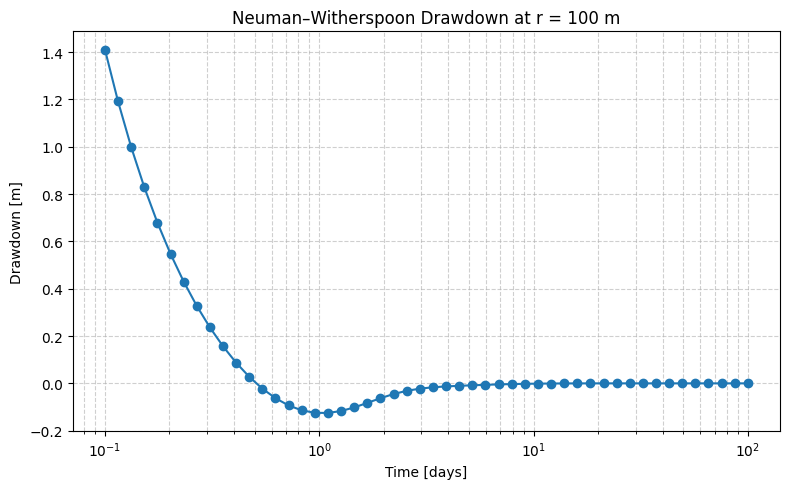

In [6]:
import matplotlib.pyplot as plt

# Parameters
Q = 1000         # m³/day
T = 500          # m²/day
S = 1e-4         # aquifer storage
b_prime = 10     # m
K_prime = 0.01   # m/day
S_prime = 1e-3   # aquitard storage
r = 100          # m

# Time vector for plotting
t_vals = np.logspace(-1, 2, 50)  # 0.1 to 100 days
s_vals = [neuman_witherspoon_drawdown(r, t, Q, T, S, b_prime, K_prime, S_prime) for t in t_vals]

# Plotting
plt.figure(figsize=(8,5))
plt.semilogx(t_vals, s_vals, marker='o')
plt.xlabel('Time [days]')
plt.ylabel('Drawdown [m]')
plt.title(f'Neuman–Witherspoon Drawdown at r = {r} m')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()